# TEST

Test the code for more spins

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [10]:
### PROBLEM PARAMETERS
L = 40         # chain length
omega = 1     # Rabi frequency
V = 0.1       # B-S interaction strength
V_ = 0.1        # bath interaction strength
beta = 0.001    # inverse temperature for the bath

T = 10        # total time of the simulation
dt = 0.1      # time step for coherece vector time evolution

cutoff = 1e-8 # cutoff for TEBD algorithm

### USEFULL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('Y')
Z = qu.pauli('Z')

### TEBD

In [11]:
### BUILDING THE HAMILTONIAN for the thermalization

O_Rabi = (omega/2)*X & I
N = (I + Z)/2 & I

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
H2 = {None: V_*N&N, (L-1, 0): V*N&N, (0, 1): V*N&N, (1, 2): V*N&N}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### BUILDING THE SPIN CHAIN

print('Building the spin chain \n')
B = np.array([1, 0, 0, 1])/np.sqrt(2)
arrays = [B for i in range(L)]

psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

psi.show()

Building Hamiltonian for L=40 

Building the spin chain 

     1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1    
... +─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─ ...
      │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │     
                                 ...                                  
     1 1 1 1 1 1 
    ●─●─●─●─●─●─+
    │ │ │ │ │ │  


In [12]:
print(f'Check for the normalization: {psi.H @ psi}\n')

Check for the normalization: 0.9999999999999911



In [13]:
### IMAGINARY TIME EVOLUTION

print('Imaginary time evolution \n')

# create the object
tebd_th = qtn.TEBD(psi, H, imag=True)

# cutoff for truncating after each infinitesimal-time operator application
tebd_th.split_opts['cutoff'] = 1e-10

tebd_th.update_to(beta/2, tol=1e-3)
psi_th = tebd_th.pt

psi_th.show() 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 1413.92%/s]

     2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2    
... +─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─ ...
      │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │     
                                 ...                                  
     2 2 2 2 2 2 
    ●─●─●─●─●─●─+
    │ │ │ │ │ │  


In [14]:
print(f'Check for the normalization beta/2: {psi_th.H @ psi_th}\n')

Check for the normalization beta/2: (0.5000000025080288-6.399022959717362e-44j)



In [15]:
### INITIAL CONDITIONS

# random initial conditions
#Rand1 = rand1 & qu.pauli('I')
#Rand2 = rand2 & qu.pauli('I')

#psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')
psi_init = psi_th.copy()
psi_init.show()

     2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2    
... +─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─ ...
      │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │     
                                 ...                                  
     2 2 2 2 2 2 
    ●─●─●─●─●─●─+
    │ │ │ │ │ │  


In [16]:
### THE SIMULATION

start = time.time()

# first I build the observables
observables_tebd = {}
results = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results[key] = []
    observables_tebd[key] = []

# dropping the identity
observables_tebd.pop('I1I2')
results.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi_init, H)

# cutoff for truncating after each infinitesimal-time operator application
tebd.split_opts['cutoff'] = cutoff

t = np.linspace(0, T, 100)
keys = results.keys()

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(t, tol=1e-3):
    for key in keys:
        ob1 = qu.pauli(key[0]) & qu.pauli('I')
        ob2 = qu.pauli(key[2]) & qu.pauli('I')
        results[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)
        
end = time.time()
print(f'Time:{int(end - start)}s')

t=10, max-bond=35: 100%|####################################################################################################################################################################################################| 100/100 [01:07<00:00,  1.47it/s]

Time:67s


In [17]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')

Check for the normalization: (0.5000000607633204-1.7064544989059136e-16j)



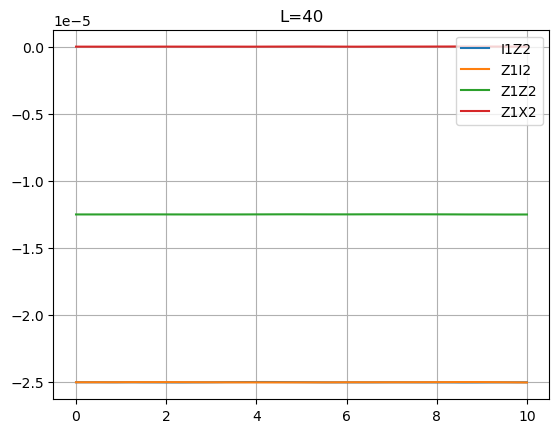

In [18]:
keys = results.keys()
keys = ['I1Z2', 'Z1I2', 'Z1Z2', 'Z1X2']

for key in keys:
    plt.plot(t, results[key], label=key)
    plt.title(f'L={L}')
plt.legend()
plt.grid()